### 2448509 Ashwin Rajan LAB 1 Task 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import sounddevice as sd

### Generate a Test `speech.wav` File (Optional)

If you don't have a `.wav` file, you can run the cell below to generate a simple test signal. It will create a 2-second sine wave at 440 Hz (the note "A") and save it as `speech.wav`. This ensures you have a valid file to work with for the rest of the lab.

In [5]:
# --- Generate a test WAV file ---
sample_rate_gen = 44100  # Hz
duration_gen = 20        # seconds
frequency_gen = 440      # Hz (A4 note)

# Generate a time vector
t_gen = np.linspace(0., duration_gen, int(sample_rate_gen * duration_gen), endpoint=False)

# Generate a sine wave
amplitude_gen = np.iinfo(np.int16).max * 0.5 # Use 50% of max amplitude
data_gen = amplitude_gen * np.sin(2. * np.pi * frequency_gen * t_gen)

# Write to a WAV file
wavfile.write("speech.wav", sample_rate_gen, data_gen.astype(np.int16))

print("Generated 'speech.wav' successfully.")

Generated 'speech.wav' successfully.


## 1. Load and Plot the Original Speech Signal

First, we need to load a speech signal from a `.wav` file. Make sure you have a speech file in your project directory or provide the correct path to it.

The code below will:
1.  Read the sampling rate and data from the `.wav` file.
2.  Normalize the audio data to be between -1 and 1.
3.  Create a time vector.
4.  Plot the speech signal's waveform.

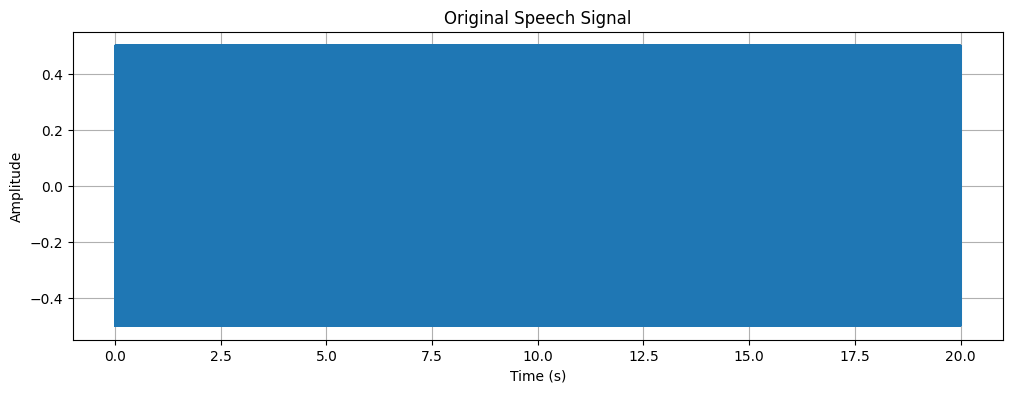

In [6]:
# (1a) Plot the time domain representation of the original speech signal.

# --- Parameters ---
# PLEASE REPLACE WITH THE PATH TO YOUR SPEECH FILE
input_filename = 'speech.wav' 

# --- Code ---
try:
    # Read the audio file
    original_rate, original_signal = wavfile.read(input_filename)

    # Normalize the signal to be in the range [-1, 1]
    if original_signal.dtype == 'int16':
        original_signal = original_signal / 32768.0
    elif original_signal.dtype == 'int32':
        original_signal = original_signal / 2147483648.0

    # Create a time axis
    duration = len(original_signal) / original_rate
    time = np.linspace(0., duration, len(original_signal))

    # Plot the original speech signal
    plt.figure(figsize=(12, 4))
    plt.plot(time, original_signal)
    plt.title('Original Speech Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found.")
    print("Please make sure the file is in the correct directory and the filename is correct.")

# You can also play the audio to hear it
# print("Playing original audio...")
# sd.play(original_signal, original_rate)
# sd.wait()


## 2. Sample the Speech Signal at Different Rates

Now, we will take the original continuous-time signal and convert it into a discrete-time signal by sampling it at different frequencies as required by the task (8kHz, 16kHz, and 44.1kHz). This process is also known as downsampling or decimation if the new sampling rate is lower than the original.

The code below will:
1.  Define a list of target sampling rates.
2.  Loop through each rate.
3.  Resample the original signal to the target rate using `scipy.signal.resample`.
4.  Plot each of the sampled signals. A stem plot is used to visualize the discrete nature of the samples.

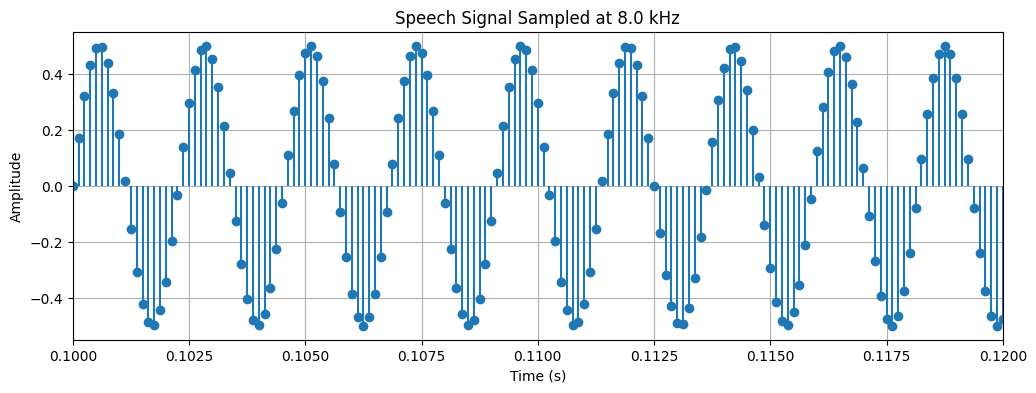

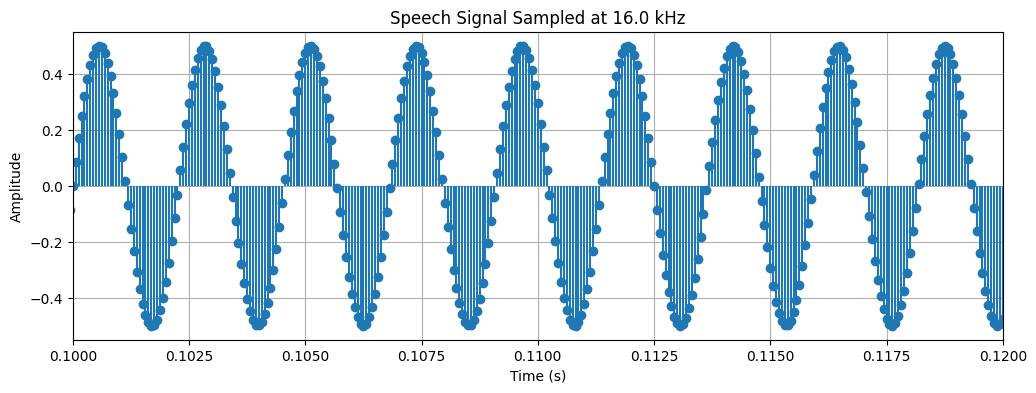

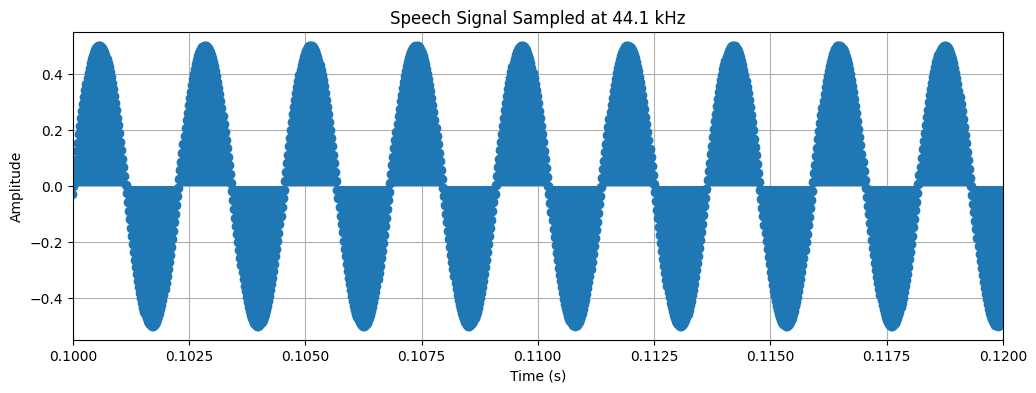

In [7]:
# (1b, 1c) Sample the speech signal and plot the sampled signals

# --- Parameters ---
target_rates = [8000, 16000, 44100]  # Hz
sampled_signals = {}

# --- Code ---
for rate in target_rates:
    # Calculate the number of samples in the resampled signal
    num_samples = int(len(original_signal) * rate / original_rate)
    
    # Resample the signal
    sampled_signal = signal.resample(original_signal, num_samples)
    sampled_signals[rate] = sampled_signal
    
    # Create a time axis for the sampled signal
    sampled_time = np.linspace(0., duration, num_samples)
    
    # Plot the sampled signal
    plt.figure(figsize=(12, 4))
    plt.stem(sampled_time, sampled_signal, basefmt=" ")
    plt.title(f'Speech Signal Sampled at {rate / 1000} kHz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # To make the plot cleaner, you might want to plot only a small segment
    plt.xlim(0.1, 0.12) # Zoom in to a 20ms segment to see the samples clearly
    plt.show()

    # You can also play the sampled audio to hear the difference
    # print(f"Playing audio sampled at {rate / 1000} kHz...")
    # sd.play(sampled_signal, rate)
    # sd.wait()


## 3. Reconstruct the Signal from Samples

After sampling, we have a discrete set of points. To get back to a continuous-like signal, we need to "fill in the gaps" between these points. This process is called **reconstruction** or **interpolation**. We will implement two basic methods:

1.  **Zero-Order Hold (ZOH):** This is the simplest method. It holds the value of each sample constant until the next sample is reached. This creates a "staircase" or blocky-looking signal. It's also known as nearest-neighbor interpolation.

2.  **Linear Interpolation:** This method connects consecutive samples with a straight line. It generally produces a smoother and more accurate reconstruction than ZOH.

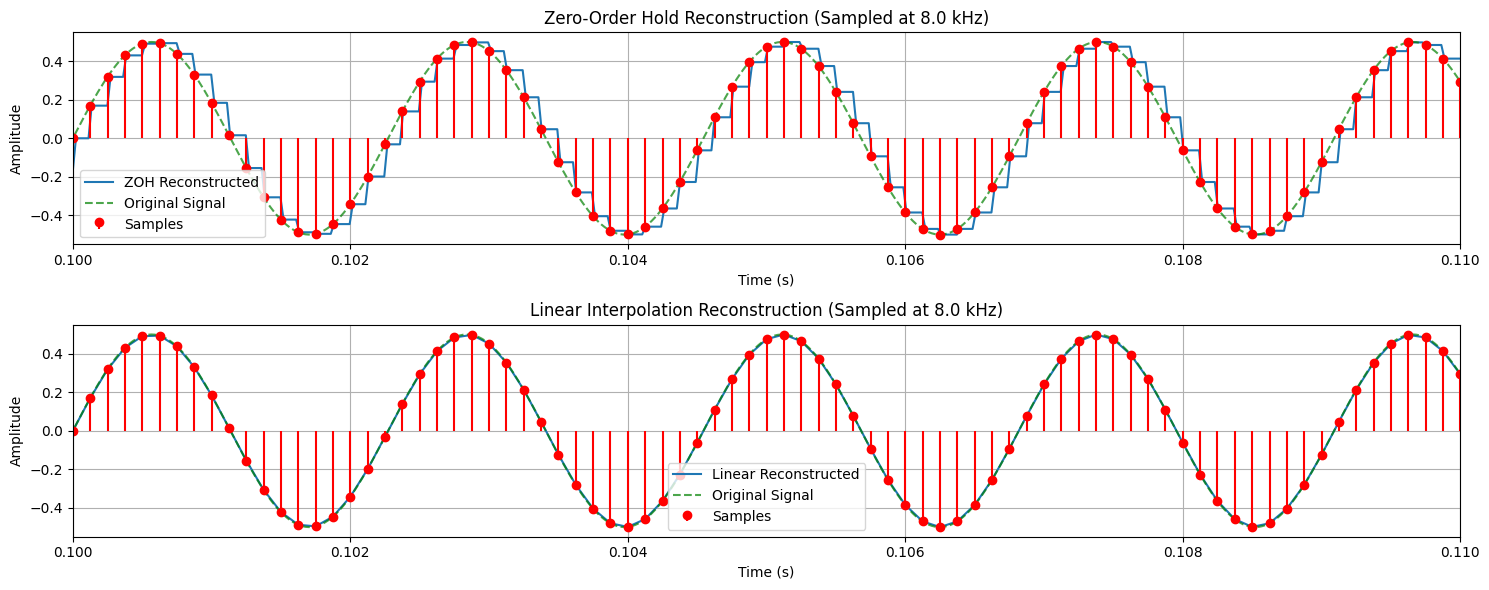

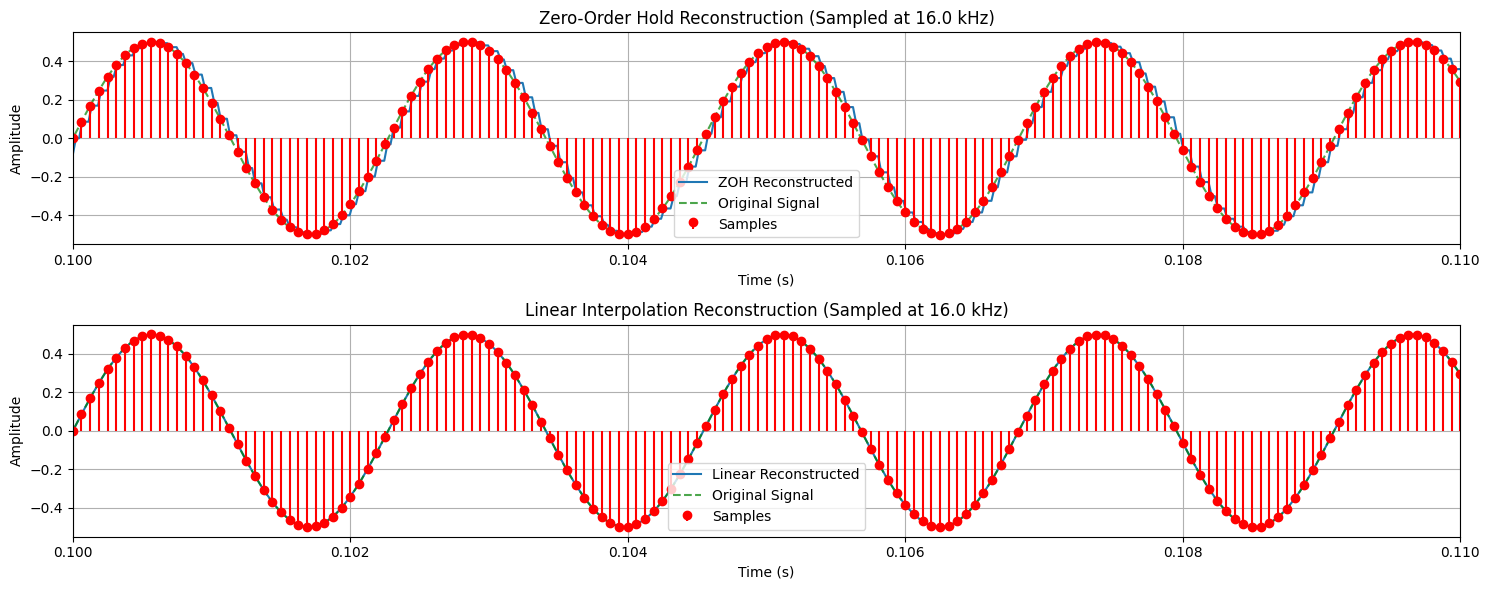

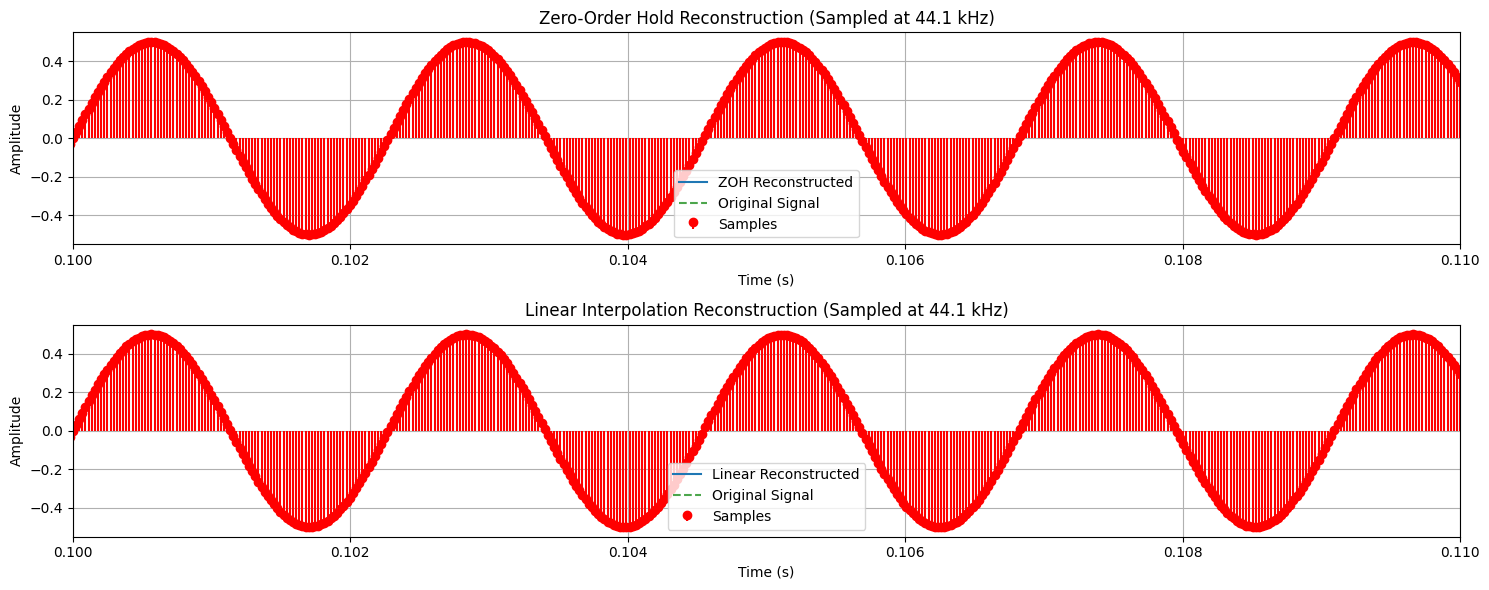

In [8]:
# (1d) Reconstruct the signal using Zero-Order Hold and Linear Interpolation
from scipy.interpolate import interp1d

# Store reconstructed signals for later analysis
reconstructed_signals_zoh = {}
reconstructed_signals_linear = {}

for rate, sampled_signal in sampled_signals.items():
    # --- Time axes ---
    # Time axis for the low-rate sampled signal
    sampled_time = np.linspace(0., duration, len(sampled_signal))
    # Time axis for the high-rate original signal (for comparison)
    original_time = np.linspace(0., duration, len(original_signal))

    # --- Zero-Order Hold (ZOH) ---
    f_zoh = interp1d(sampled_time, sampled_signal, kind='zero')
    reconstructed_zoh = f_zoh(original_time)
    reconstructed_signals_zoh[rate] = reconstructed_zoh

    # --- Linear Interpolation ---
    f_linear = interp1d(sampled_time, sampled_signal, kind='linear')
    reconstructed_linear = f_linear(original_time)
    reconstructed_signals_linear[rate] = reconstructed_linear

    # --- Plotting ---
    plt.figure(figsize=(15, 6))
    
    # Plot ZOH
    plt.subplot(2, 1, 1)
    plt.plot(original_time, reconstructed_zoh, label='ZOH Reconstructed')
    plt.plot(original_time, original_signal, 'g--', label='Original Signal', alpha=0.7)
    plt.stem(sampled_time, sampled_signal, 'r', markerfmt='ro', basefmt=' ', label='Samples')
    plt.title(f'Zero-Order Hold Reconstruction (Sampled at {rate/1000} kHz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.xlim(0.1, 0.11) # Zoom in to see the detail
    plt.grid(True)

    # Plot Linear Interpolation
    plt.subplot(2, 1, 2)
    plt.plot(original_time, reconstructed_linear, label='Linear Reconstructed')
    plt.plot(original_time, original_signal, 'g--', label='Original Signal', alpha=0.7)
    plt.stem(sampled_time, sampled_signal, 'r', markerfmt='ro', basefmt=' ', label='Samples')
    plt.title(f'Linear Interpolation Reconstruction (Sampled at {rate/1000} kHz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.xlim(0.1, 0.11) # Zoom in to see the detail
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


## 4. Calculate Mean Squared Error (MSE)

Visual inspection is good, but a quantitative measure is better for comparing the reconstruction quality. We will now calculate the Mean Squared Error (MSE) between the original signal and each of our reconstructed signals.

The formula for MSE is:
$$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (Y_i - \hat{Y}_i)^2 $$

Where:
-   `N` is the total number of samples.
-   `Yi` is the value of the original signal at sample `i`.
-   `Ŷi` is the value of the reconstructed signal at sample `i`.

A smaller MSE value indicates that the reconstructed signal is a better approximation of the original signal.

In [9]:
# (1e) Calculate the Mean Squared Error (MSE)

def mean_squared_error(original, reconstructed):
    """Calculates the Mean Squared Error between two signals."""
    return np.mean((original - reconstructed)**2)

print("--- Mean Squared Error (MSE) ---")
for rate in target_rates:
    # Ensure the original signal is trimmed to the same length as the reconstructed one
    # This is important if resampling caused a slight length mismatch
    min_len = min(len(original_signal), len(reconstructed_signals_zoh[rate]))
    trimmed_original = original_signal[:min_len]
    
    # MSE for Zero-Order Hold
    mse_zoh = mean_squared_error(trimmed_original, reconstructed_signals_zoh[rate][:min_len])
    
    # MSE for Linear Interpolation
    mse_linear = mean_squared_error(trimmed_original, reconstructed_signals_linear[rate][:min_len])
    
    print(f"\nSampling Rate: {rate/1000} kHz")
    print(f"  MSE (Zero-Order Hold): {mse_zoh:.10f}")
    print(f"  MSE (Linear Interpolation): {mse_linear:.10f}")

--- Mean Squared Error (MSE) ---

Sampling Rate: 8.0 kHz
  MSE (Zero-Order Hold): 0.0142083437
  MSE (Linear Interpolation): 0.0033024013

Sampling Rate: 16.0 kHz
  MSE (Zero-Order Hold): 0.0029287700
  MSE (Linear Interpolation): 0.0005043616

Sampling Rate: 44.1 kHz
  MSE (Zero-Order Hold): 0.0000000000
  MSE (Linear Interpolation): 0.0000000000


## 5. Inference

Based on the plots and the Mean Squared Error (MSE) values calculated above, write your conclusion here.

**Key points to consider:**

*   **Effect of Sampling Rate:** How did the MSE change as the sampling rate increased from 8 kHz to 44.1 kHz? What does this tell you about the relationship between sampling rate and reconstruction accuracy?
*   **Comparison of Reconstruction Methods:** For any given sampling rate, which method (Zero-Order Hold or Linear Interpolation) consistently produced a lower MSE? What does this imply about the effectiveness of the two methods?
*   **Audible Quality (Optional):** If you played the audio for each reconstructed signal, how did the sound quality change with the sampling rate and reconstruction method? Did the audible quality match what the MSE values suggest?
*   **Nyquist Theorem:** The original signal was a 440 Hz sine wave. According to the Nyquist-Shannon sampling theorem, what is the minimum sampling rate required to perfectly reconstruct this signal? How does this relate to your results for the 8 kHz, 16 kHz, and 44.1 kHz rates?
